In [ ]:
#!git clone https://gitlab.com/checkthat_lab/clef2021-checkthat-lab.git

fatal: destination path 'clef2021-checkthat-lab' already exists and is not an empty directory.


In [ ]:
#%cd /content/clef2021-checkthat-lab/task1/data/subtask-1--arabic

/content/clef2021-checkthat-lab/task1/data/subtask-1--arabic


In [ ]:
#!unzip v2.zip

Archive:  v2.zip
  inflating: CT21-AR-Dev-T1-Labels.tsv  
replace CT21-AR-Dev-T1-Tweets.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
!pip install pyarabic

In [ ]:
!pip install transformers==3

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,AutoTokenizer,AutoModelForMaskedLM

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm
import random
import os


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
set_seed(66)

In [ ]:
data = pd.read_csv('/content/clef2021-checkthat-lab/task1/data/subtask-1--arabic/CT21-AR-Train-T1-Labels.tsv',sep='\t',error_bad_lines=False)

In [ ]:
data

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,CT20-AR-01,1221949644554588160,https://twitter.com/user/status/12219496445545...,وأي خيانة أكبر من خيانة الدين ،، الوطن ،، الهو...,0,0
1,CT20-AR-01,1222030473385345028,https://twitter.com/user/status/12220304733853...,صباح الخير على فلسطين وقدسها وشعبها ومهجرينها ...,0,0
2,CT20-AR-01,1222035929105338368,https://twitter.com/user/status/12220359291053...,ذنبگ أنگ جميله گ يوسف وخانگ العالم گ أاخواته 💔...,0,0
3,CT20-AR-01,1222048121145962496,https://twitter.com/user/status/12220481211459...,لا يلزمك ان تكون فلسطينياً لتحب فلسطين، حُبها ...,0,0
4,CT20-AR-01,1222053294266372096,https://twitter.com/user/status/12220532942663...,#مناصرون رحل البروفسور زيك فريد فوغل . رئيس قس...,0,0
...,...,...,...,...,...,...
3434,CT20-AR-30,1229511354714927105,https://twitter.com/user/status/12295113547149...,#سفيه_الدوحه_وجزيه_المرتزقه ماكسر خاطري الا حم...,0,0
3435,CT20-AR-30,1229512831114108934,https://twitter.com/user/status/12295128311141...,انتصار جديد لـ #قطر وصفعة قاسية لدول الحصار ال...,0,0
3436,CT20-AR-30,1229513572633530368,https://twitter.com/user/status/12295135726335...,@alkhor_live @ama4425 الله اكبر هذا يعتبر اكبر...,0,0
3437,CT20-AR-30,1229529046930903040,https://twitter.com/user/status/12295290469309...,@Alg27010 @ramlo_ramlo غير تنضحك مع راملو ... ...,0,0


In [ ]:
dev = pd.read_csv('/content/clef2021-checkthat-lab/task1/data/subtask-1--arabic/CT21-AR-Dev-T1-Labels.tsv',sep='\t',error_bad_lines=False)
#dev = pd.read_csv('/content/clef2021-checkthat-lab/task1/scorer/CT21-AR-Dev-T1-Labels.tsv',sep='\t',error_bad_lines=False)


In [ ]:
dev

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,CT20-AR-02,1221223213583294470,https://twitter.com/user/status/12212232135832...,باقي هذا المجرم الجبار المتكبر وابنائه الجبابر...,1,0
1,CT20-AR-02,1221224671208755211,https://twitter.com/user/status/12212246712087...,الان عودة الاشتباكات العنيفه في نهم والجيش الو...,1,1
2,CT20-AR-02,1221226319243108353,https://twitter.com/user/status/12212263192431...,الوية العمالقة تعلن النفير العام للاستعداد لاق...,0,0
3,CT20-AR-02,1221243369348902912,https://twitter.com/user/status/12212433693489...,في الاسواق-اغاني جديده : الحوثيين راح يفبركون ...,1,0
4,CT20-AR-02,1221253458394779649,https://twitter.com/user/status/12212534583947...,#السعودية و #الإمارات من محرريين لليمن إلى احت...,1,0
...,...,...,...,...,...,...
656,CT20-AR-27,1233386563331121153,https://twitter.com/user/status/12333865633311...,الدكتور عبد الرزاق مقري: التيار العلماني المبي...,1,1
657,CT20-AR-27,1233403769016242176,https://twitter.com/user/status/12334037690162...,#الجمعة_54 حيا الله الأحرار.... جمعة قوية في م...,1,1
658,CT20-AR-27,1233404098751475712,https://twitter.com/user/status/12334040987514...,# 28 فبراير 2020. #الجمعة_54 من الحراك.. # الث...,0,0
659,CT20-AR-27,1233406731562225665,https://twitter.com/user/status/12334067315622...,شركة المراعي السعودية العالمية بمنتجات ذات جود...,1,1


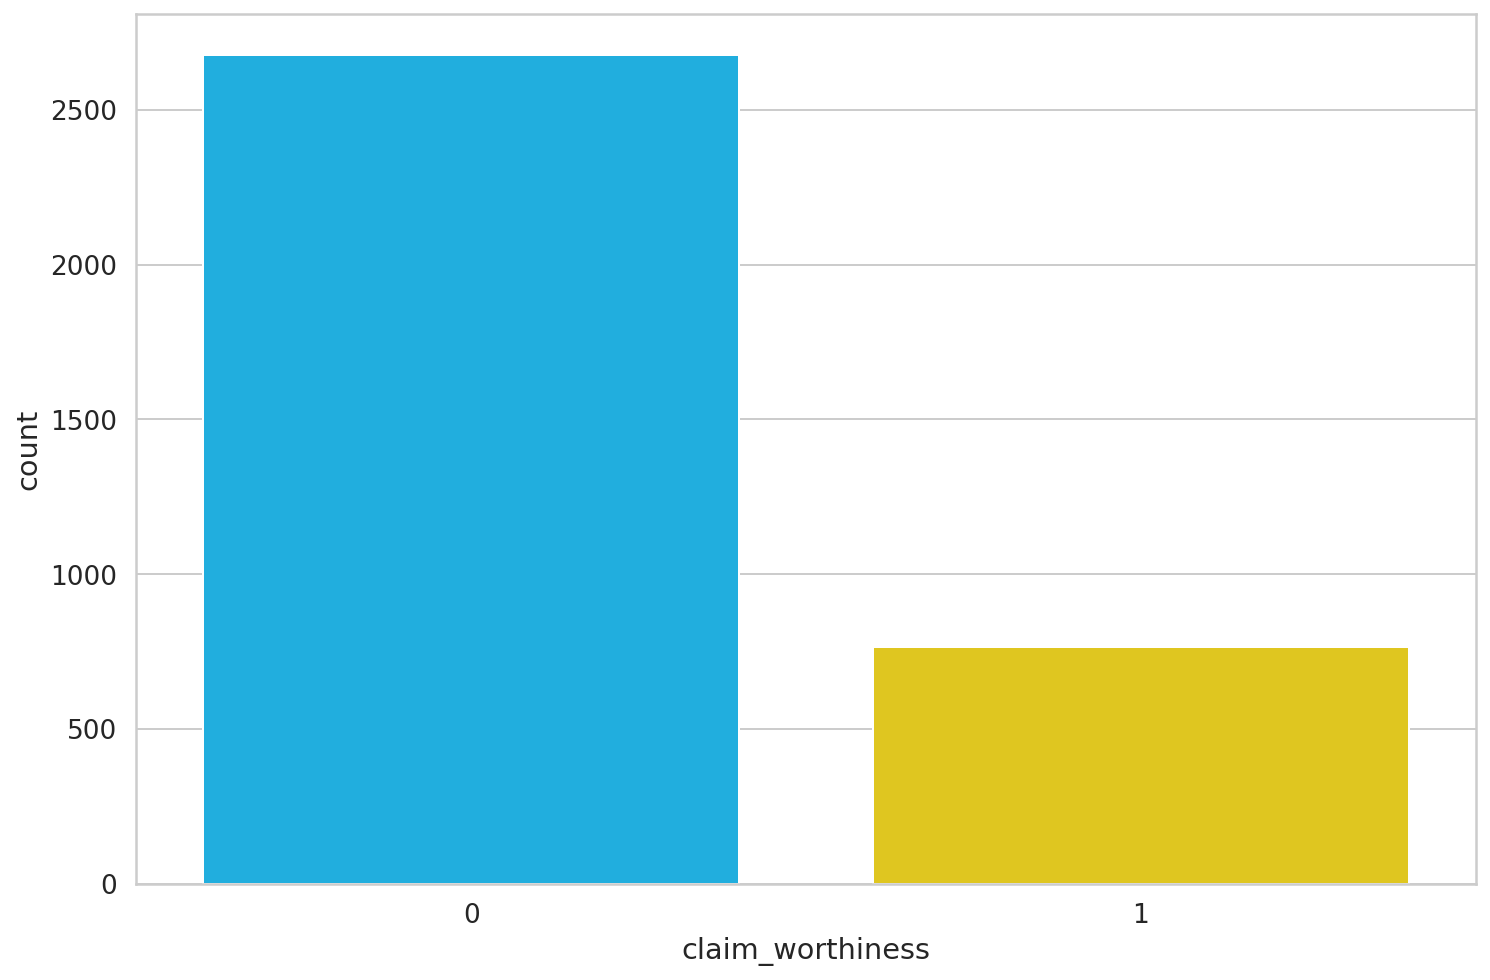

In [ ]:
sns.countplot(data=data,x="claim_worthiness")

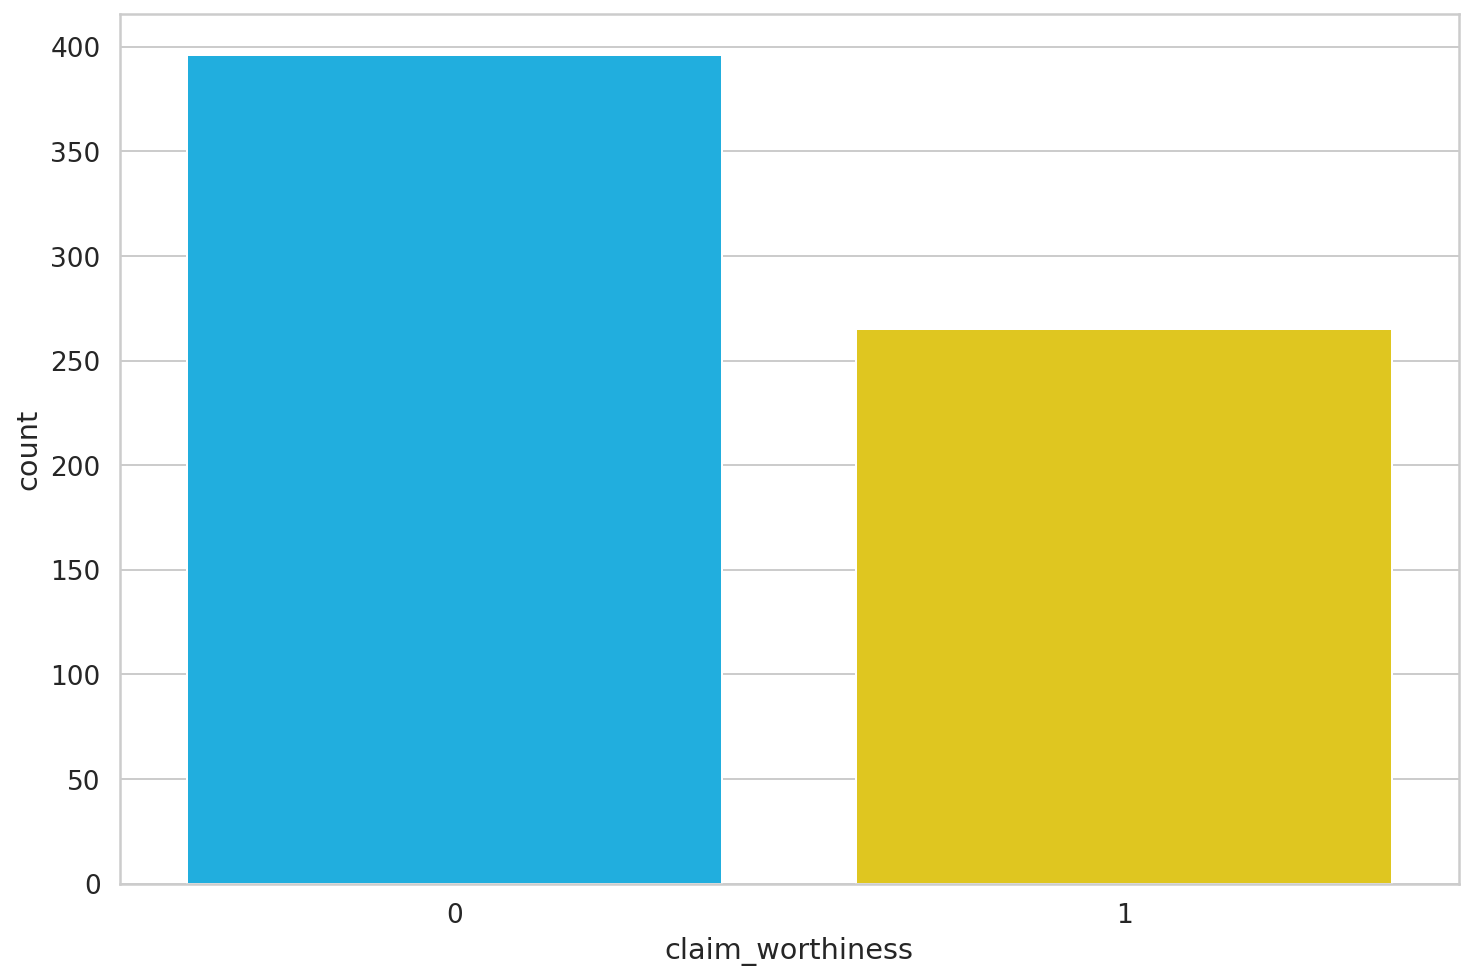

In [ ]:
sns.countplot(data=dev,x="claim_worthiness")

In [ ]:
data.topic_id.unique()

array(['CT20-AR-01', 'CT20-AR-03', 'CT20-AR-08', 'CT20-AR-12',
       'CT20-AR-14', 'CT20-AR-23', 'CT20-AR-28_w1', 'CT20-AR-28_w2',
       'CT20-AR-29', 'CT20-AR-30'], dtype=object)

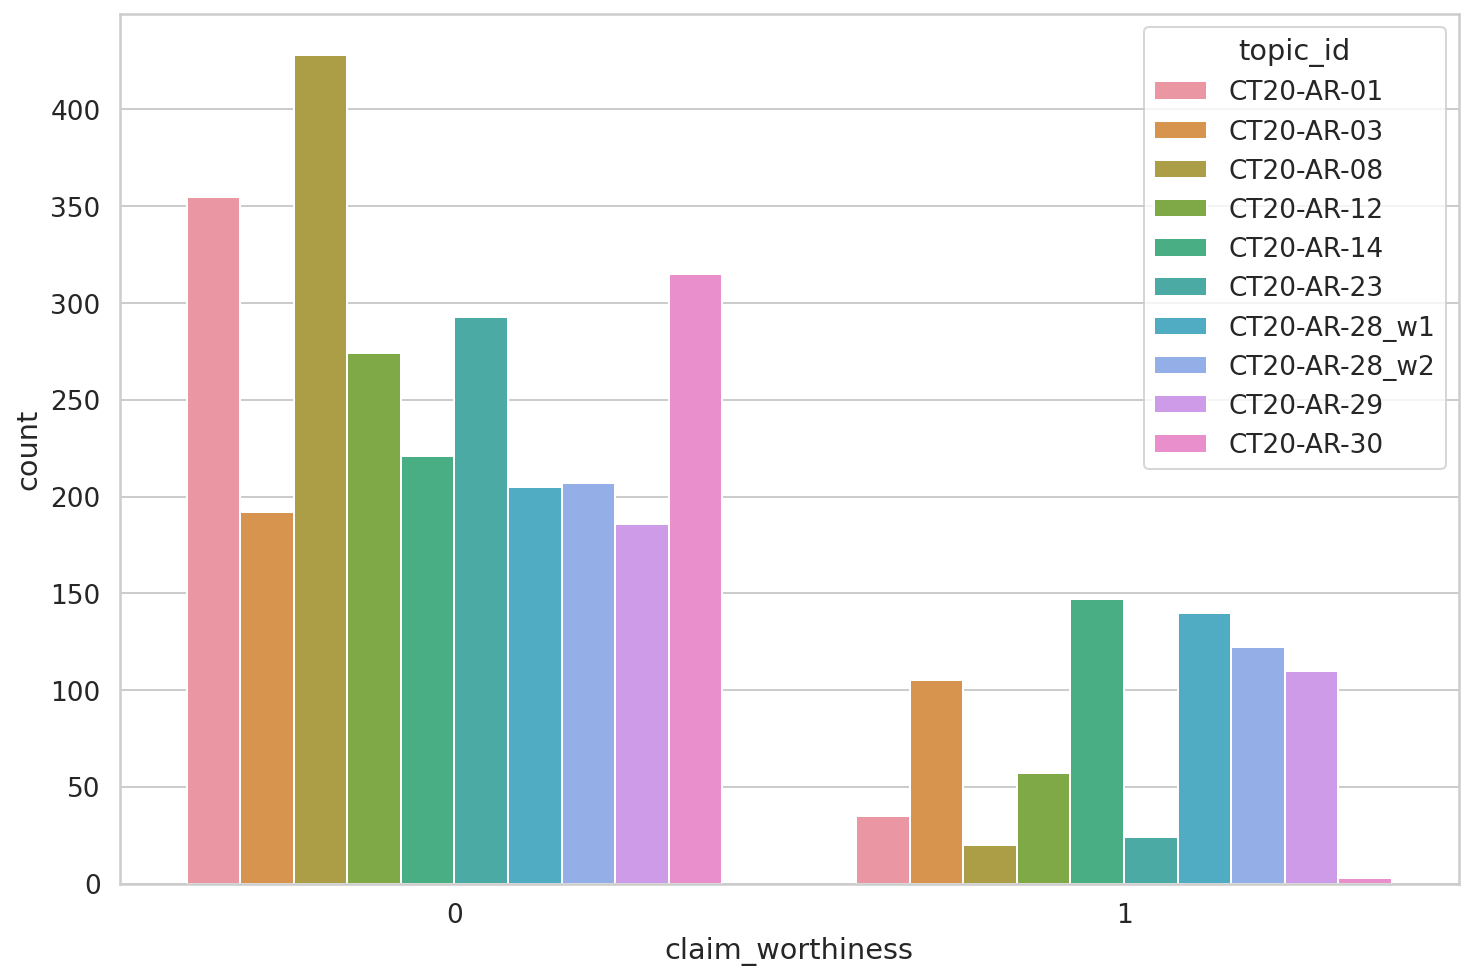

In [ ]:
sns.countplot(data=data,x="claim_worthiness",hue="topic_id")

In [ ]:
topics_to_undersample = ['CT20-AR-30','CT20-AR-23','CT20-AR-12','CT20-AR-08','CT20-AR-01']

In [ ]:
data.loc[3121:3151]

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
3121,CT20-AR-30,1229194023568580608,https://twitter.com/user/status/12291940235685...,#سفيه_الدوحه_وجزيه_المرتزقه قال شو أبشروا بالخ...,0,0
3122,CT20-AR-30,1229194209699168258,https://twitter.com/user/status/12291942096991...,@fdeet_alnssr زادت مكافأة مرتزقة #قناة_الجزيرة...,0,0
3123,CT20-AR-30,1229194728408829952,https://twitter.com/user/status/12291947284088...,#سفيه_الدوحه_وجزيه_المرتزقه الشنقيطي لك الله ،...,0,0
3124,CT20-AR-30,1229194730807988225,https://twitter.com/user/status/12291947308079...,#سفيه_الدوحه_وجزيه_المرتزقه و الله يا عصمان آآ...,0,0
3125,CT20-AR-30,1229194862689427457,https://twitter.com/user/status/12291948626894...,#سفيه_الدوحه_وجزيه_المرتزقه عندما تشترى الأدمغ...,0,0
3126,CT20-AR-30,1229194926203834369,https://twitter.com/user/status/12291949262038...,@allahim استلم يابو خالد البيان المسرب من داخل...,0,0
3127,CT20-AR-30,1229195485258362880,https://twitter.com/user/status/12291954852583...,@OlaAlfares مبروك المكافأه اثبتي أنك أقوى ممن ...,0,0
3128,CT20-AR-30,1229195812036661249,https://twitter.com/user/status/12291958120366...,#سفيه_الدوحه_وجزيه_المرتزقه و يزعلون إذا قلنا ...,0,0
3129,CT20-AR-30,1229196072465129472,https://twitter.com/user/status/12291960724651...,قرابة الـ2 مليون دولار مكافأة صرفتها قطر على 8...,0,0
3130,CT20-AR-30,1229196544869589000,https://twitter.com/user/status/12291965448695...,مقهور صراحه على الشنقيطي طلع حمار مكده 😂😂 #سفي...,0,0


In [ ]:
for topic in topics_to_undersample:
  k = len(data[(data['claim_worthiness']== 0)&(data['topic_id'] == topic )])
  idx = data[(data['claim_worthiness']== 0)&(data['topic_id'] == topic)].index
  data.drop(data.index[idx[0]:idx[k*2//3]-1], inplace=True)

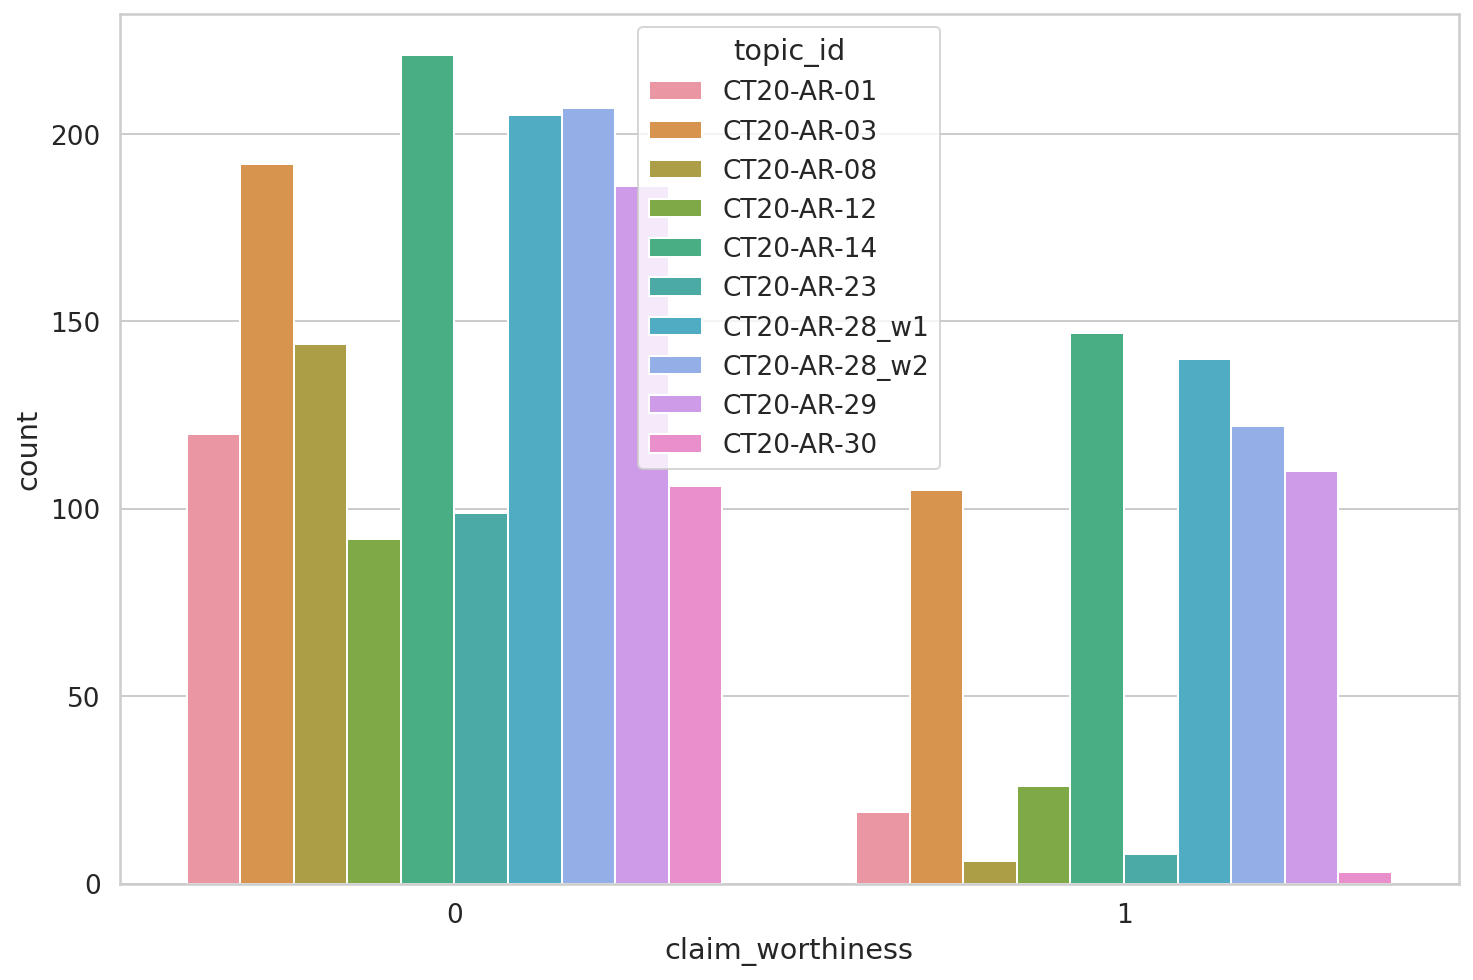

In [ ]:
sns.countplot(data=data,x="claim_worthiness",hue="topic_id")

In [ ]:
data.reset_index()

,index,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,251,CT20-AR-01,1222558536384774144,https://twitter.com/user/status/12225585363847...,مع إحترام الحرية الشخصية بتويتر وكل شخص حر بما...,0,0
1,252,CT20-AR-01,1222559280768978945,https://twitter.com/user/status/12225592807689...,قريبا ستتهاوى الأقنعة.... الكيان لم يعد يرضى ب...,0,0
2,253,CT20-AR-01,1222561606158233600,https://twitter.com/user/status/12225616061582...,كم هي مؤلمة حرقة القلب و تلك الغصة التي تطعن ر...,0,0
3,254,CT20-AR-01,1222561821757988865,https://twitter.com/user/status/12225618217579...,الإمام السيد علي الخامنئي: إن ما يسمى “صفقة ال...,0,0
4,255,CT20-AR-01,1222562015346135040,https://twitter.com/user/status/12225620153461...,في يوم آتٍ قريب؛ سيخلصها رجال أتقياء يحبون الم...,0,0
...,...,...,...,...,...,...,...
2253,3434,CT20-AR-30,1229511354714927105,https://twitter.com/user/status/12295113547149...,#سفيه_الدوحه_وجزيه_المرتزقه ماكسر خاطري الا حم...,0,0
2254,3435,CT20-AR-30,1229512831114108934,https://twitter.com/user/status/12295128311141...,انتصار جديد لـ #قطر وصفعة قاسية لدول الحصار ال...,0,0
2255,3436,CT20-AR-30,1229513572633530368,https://twitter.com/user/status/12295135726335...,@alkhor_live @ama4425 الله اكبر هذا يعتبر اكبر...,0,0
2256,3437,CT20-AR-30,1229529046930903040,https://twitter.com/user/status/12295290469309...,@Alg27010 @ramlo_ramlo غير تنضحك مع راملو ... ...,0,0


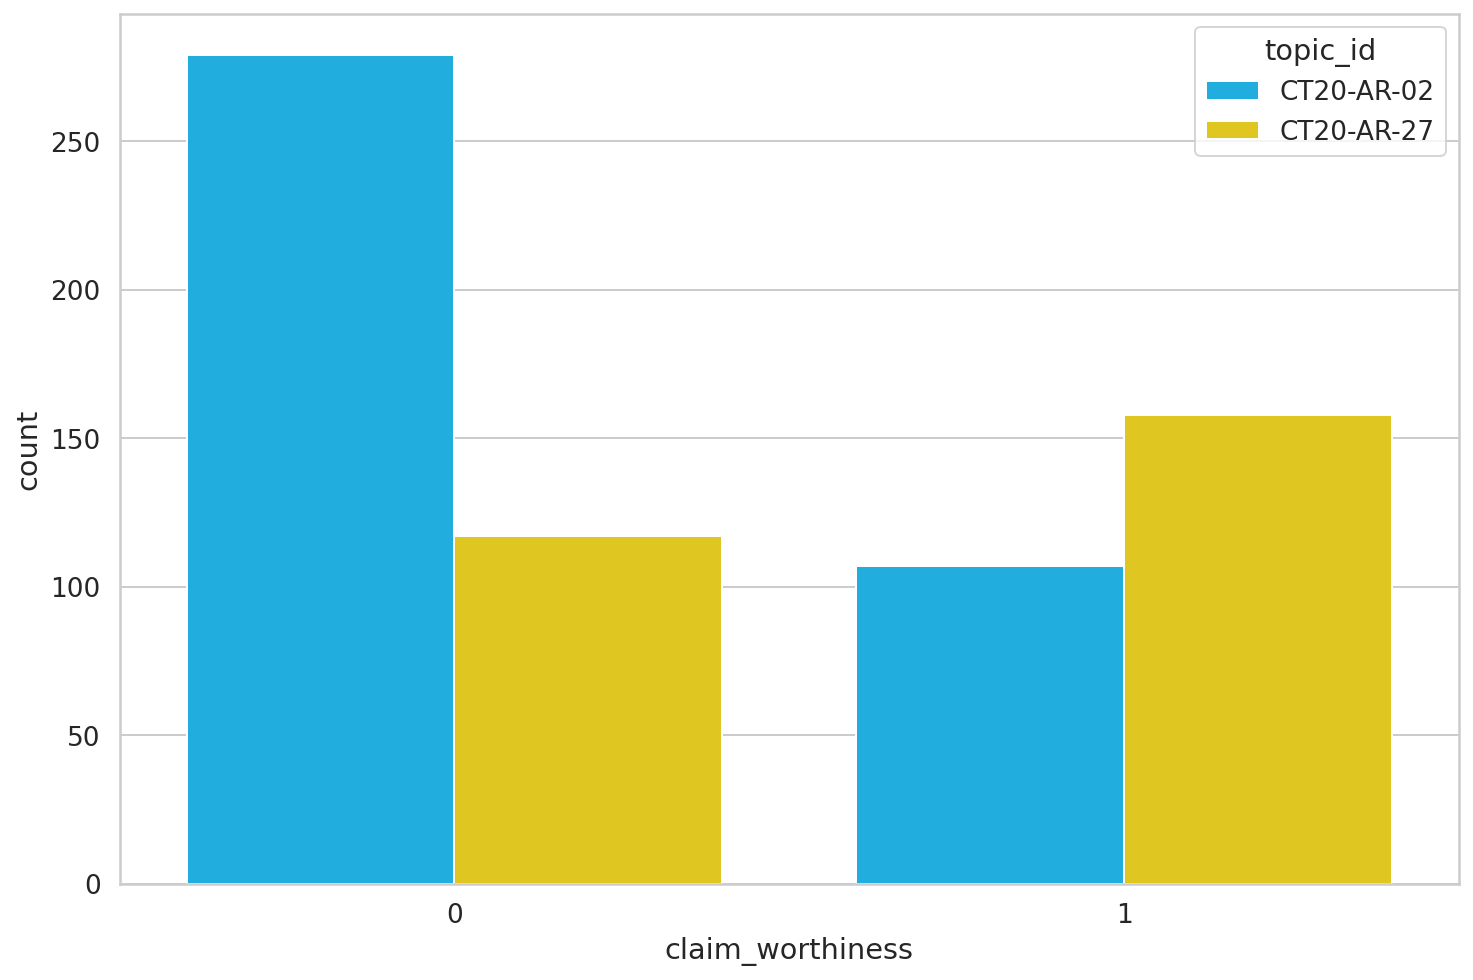

In [ ]:
sns.countplot(data=dev,x="claim_worthiness",hue="topic_id")

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
import re
from os import listdir
from os.path import isfile, join
from pyarabic import araby


def process(text):
    text = araby.strip_tashkeel(text) #delete *tashkil
    text = re.sub('\ـ+', ' ', text)  # delete letter madda
    text = re.sub("^https?:\/\/.*[\r\n]*", '', text, flags=re.MULTILINE)
    #text = re.sub("^(@[A-Za-z0-9_]+)|([^0-9A-Za-z])"," ",text)

    text = " ".join(text.split()) #delete multispace
    return text
def remove_english(value):
    output = re.sub(r'\s*[A-Za-z0-9_]+\b', '' , value)
    results=re.sub(r'\W', ' ', output, flags=re.UNICODE)
    return results

In [ ]:
data["tweet_text"]=data["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
data.tweet_text

0       عزيزي المواطن   والمقيم المدخنين هم أكثر عرضة ...
1        الحرية_للمحامي_هاني_حسين له حق علينا ان ننصره...
2       ما يغشوكم القحاته و يقولو ليكم م عارفين لا عار...
3           ٠ التحرش سببه ملابس البنت ولا أخلاق الراجل  ٠
4        خبر   لواء الشمال الديمقراطي السوري  تركيا تس...
                              ...                        
2253    يعيش  البدون في حالة من العزل والتدقيق والفحص ...
2254    أيها المجاهدون الأبرار والثوار الأحرار في  إدل...
2255          التطبيع حصل غصبا عنك و عن عين اسيادك الك...
2256        لهذه الأسباب تدخلت تركيا في ليبيا            
2257     عاجل  رئيس منظمة ضحايا لحقوق الإنسان ناصر اله...
Name: tweet_text, Length: 2258, dtype: object

In [ ]:
data["tweet_text"]=data["tweet_text"].apply(lambda x : process(x))
data["tweet_text"]=data["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
dev["tweet_text"]=dev["tweet_text"].apply(lambda x : process(x))
dev["tweet_text"]=dev["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
data

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,CT20-AR-28_w1,1240319232858095616,https://twitter.com/user/status/12403192328580...,عزيزي المواطن والمقيم المدخنين هم أكثر عرضة لل...,1,1
1,CT20-AR-23,1231255812208652289,https://twitter.com/user/status/12312558122086...,الحرية_للمحامي_هاني_حسين له حق علينا ان ننصره ...,0,0
2,CT20-AR-12,1225114707033456640,https://twitter.com/user/status/12251147070334...,ما يغشوكم القحاته و يقولو ليكم م عارفين لا عار...,0,0
3,CT20-AR-08,1223303463960023041,https://twitter.com/user/status/12233034639600...,٠ التحرش سببه ملابس البنت ولا أخلاق الراجل ٠,0,0
4,CT20-AR-14,1225486817329401858,https://twitter.com/user/status/12254868173294...,خبر لواء الشمال الديمقراطي السوري تركيا تستغل ...,1,1
...,...,...,...,...,...,...
2253,CT20-AR-23,1231175981739671552,https://twitter.com/user/status/12311759817396...,يعيش البدون في حالة من العزل والتدقيق والفحص م...,0,0
2254,CT20-AR-01,1222588768194048000,https://twitter.com/user/status/12225887681940...,أيها المجاهدون الأبرار والثوار الأحرار في إدلب...,0,0
2255,CT20-AR-12,1225117004954263552,https://twitter.com/user/status/12251170049542...,التطبيع حصل غصبا عنك و عن عين اسيادك الكيزان ع...,0,0
2256,CT20-AR-14,1225686147990315008,https://twitter.com/user/status/12256861479903...,لهذه الأسباب تدخلت تركيا في ليبيا,0,0


In [ ]:
%cd /content/

/content


In [ ]:
sub = pd.DataFrame()
sub['tweet_id'] = dev.tweet_id.copy()
sub['topic_id'] = dev.tweet_id.copy()
sub['score'] = 0
sub['run_id'] = "Model_1"


In [ ]:
data.drop(["topic_id","tweet_url","tweet_id","claim"],axis=1,inplace=True)

In [ ]:
dev.drop(["topic_id","tweet_url","tweet_id","claim"],axis=1,inplace=True)

In [ ]:
data

,tweet_text,claim_worthiness
0,عزيزي المواطن والمقيم المدخنين هم أكثر عرضة لل...,1
1,الحرية_للمحامي_هاني_حسين له حق علينا ان ننصره ...,0
2,ما يغشوكم القحاته و يقولو ليكم م عارفين لا عار...,0
3,٠ التحرش سببه ملابس البنت ولا أخلاق الراجل ٠,0
4,خبر لواء الشمال الديمقراطي السوري تركيا تستغل ...,1
...,...,...
2253,يعيش البدون في حالة من العزل والتدقيق والفحص م...,0
2254,أيها المجاهدون الأبرار والثوار الأحرار في إدلب...,0
2255,التطبيع حصل غصبا عنك و عن عين اسيادك الكيزان ع...,0
2256,لهذه الأسباب تدخلت تركيا في ليبيا,0


In [ ]:
train, val = train_test_split(data, test_size=0.15,random_state=23)

In [ ]:
train

,tweet_text,claim_worthiness
2201,في كل المحاور ت سطر الانتصارات على الشيطان الأ...,0
748,صفحة من القران يوميا كفيلة بأن تبعدك عن هجره و...,0
1083,فيديو الحراك الشعبي بمدينة وهران يرفض استقبال ...,1
610,وزراء خارجية مجموعة الدول الصناعية لا يستطيعون...,1
990,القفز إلى استنتاجات غير مثبتة وإيراد وقائع غير...,0
...,...,...
1512,من المصابين بال كورونا_فيروس يتعافون تلقائيا و...,1
1993,تأكيدات حكومية ألمانية على أهمية التوصل إلى عق...,0
1064,مع انتشار وباء كورونا إليكم النصيحة النبوية ﷺ ...,0
742,أنظروا للمنطقة جيد ا تركيا وروسيا في سوريا ترك...,0


In [ ]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

###Tokenisation

In [ ]:
PRE_TRAINED_MODEL_NAME = 'aubmindlab/bert-base-arabertv01'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
train.tweet_text[1]

'صفحة من القران يوميا كفيلة بأن تبعدك عن هجره واتكفل انا بتنزيلها يوميا إن شاء الله سورة يوسف من الآية ١٠٤ الى الآية ١١١ فيروس_كورونا'

In [ ]:
sample_txt = train.tweet_text[1]

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: صفحة من القران يوميا كفيلة بأن تبعدك عن هجره واتكفل انا بتنزيلها يوميا إن شاء الله سورة يوسف من الآية ١٠٤ الى الآية ١١١ فيروس_كورونا
   Tokens: ['صفحة', 'من', 'القران', 'يوميا', 'كفيل', '##ة', 'بان', 'تبعد', '##ك', 'عن', 'هجر', '##ه', 'و', '##ات', '##ك', '##ف', '##ل', 'ان', '##ا', 'بتن', '##زيل', '##ها', 'يوميا', 'ان', 'شاء', 'الله', 'سورة', 'يوسف', 'من', 'الا', '##ية', '١٠', '##٤', 'الى', 'الا', '##ية', '١١', '##١', 'فيروس', '[UNK]', 'كورونا']
Token IDs: [9295, 731, 33748, 28764, 10436, 885, 1574, 6915, 905, 631, 3793, 909, 112, 4604, 905, 903, 906, 420, 883, 1584, 15607, 4773, 28764, 420, 2560, 6067, 8953, 14078, 731, 1498, 4784, 785, 917, 1520, 1498, 4784, 786, 914, 23586, 60122, 37385]


In [ ]:
len(tokens)

41

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=120,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'صفحة',
 'من',
 'القران',
 'يوميا',
 'كفيل',
 '##ة',
 'بان',
 'تبعد',
 '##ك',
 'عن',
 'هجر',
 '##ه',
 'و',
 '##ات',
 '##ك',
 '##ف',
 '##ل',
 'ان',
 '##ا',
 'بتن',
 '##زيل',
 '##ها',
 'يوميا',
 'ان',
 'شاء',
 'الله',
 'سورة',
 'يوسف',
 'من',
 'الا',
 '##ية',
 '١٠',
 '##٤',
 'الى',
 'الا',
 '##ية',
 '١١',
 '##١',
 'فيروس',
 '[UNK]',
 'كورونا',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PA

In [ ]:
class Tokenisation(Dataset):
    
    
    def __init__(self, data, targets, tokenizer, max_len):
        self.data = data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_vid = self.tokenizer.vocab["[PAD]"]
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())
        target = self.targets
        
        encoding = self.tokenizer.encode_plus(
          data,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        ids = encoding['input_ids']
        masks = encoding['attention_mask']
        token_type_ids = encoding['input_ids']
        
        true_seq_length = len(encoding['input_ids'][0])
        pad_size = self.max_len - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        ids = torch.cat((encoding['input_ids'][0], pad_ids))
        
        
        #padding_len = self.max_len - len(ids)
        #ids = ids + ([0] * padding_len)
        #masks = ids + ([0] * padding_len)
        #token_type_ids = token_type_ids + ([0] * padding_len)
        
        return {
          'text': data,
          'input_ids': ids.flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target[item], dtype=torch.long)
        }

In [ ]:
def dataLoader(df, tokenizer, max_len, batch_size):
    ds = Tokenisation(
    data=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

In [ ]:
train.rename(columns={'tweet_text': 'text'}, inplace=True)
train.rename(columns={'claim_worthiness': 'label'}, inplace=True)
val.rename(columns={'tweet_text': 'text'}, inplace=True)
val.rename(columns={'claim_worthiness': 'label'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
BATCH_SIZE = 32
MAX_LEN = 150

train_data_loader = dataLoader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataLoader(val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = dataLoader(test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 150])
torch.Size([32, 150])
torch.Size([32])


###Building the model


In [ ]:
class TextClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        

            
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #print(pooled_output)
        output = self.drop(pooled_output)
        return self.out(output)
    
    def unfreeze(self,start_layer,end_layer):
        def children(m):
            return m if isinstance(m, (list, tuple)) else list(m.children())
        def set_trainable_attr(m, b):
            m.trainable = b
            for p in m.parameters():
                p.requires_grad = b
        def apply_leaf(m, f):
            c = children(m)
            if isinstance(m, nn.Module):
                f(m)
            if len(c) > 0:
                for l in c:
                    apply_leaf(l, f)
        def set_trainable(l, b):
            apply_leaf(l, lambda m: set_trainable_attr(m, b))

        # You can unfreeze the last layer of bert by calling set_trainable(model.bert.encoder.layer[23], True)
        set_trainable(self.bert, False)
        for i in range(start_layer, end_layer+1):
            set_trainable(self.bert.encoder.layer[i], True)


In [ ]:
len(train.label.unique())

2

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model = TextClassifier(len(train.label.unique()))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 150])
torch.Size([32, 150])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4921, 0.5079],
        [0.5033, 0.4967],
        [0.5058, 0.4942],
        [0.5851, 0.4149],
        [0.7330, 0.2670],
        [0.3873, 0.6127],
        [0.5192, 0.4808],
        [0.4617, 0.5383],
        [0.4059, 0.5941],
        [0.4632, 0.5368],
        [0.5670, 0.4330],
        [0.6830, 0.3170],
        [0.4598, 0.5402],
        [0.5422, 0.4578],
        [0.7177, 0.2823],
        [0.3637, 0.6363],
        [0.5149, 0.4851],
        [0.4742, 0.5258],
        [0.4170, 0.5830],
        [0.5561, 0.4439],
        [0.4259, 0.5741],
        [0.5292, 0.4708],
        [0.4554, 0.5446],
        [0.4132, 0.5868],
        [0.4736, 0.5264],
        [0.6059, 0.3941],
        [0.5770, 0.4230],
        [0.4705, 0.5295],
        [0.4739, 0.5261],
        [0.4939, 0.5061],
        [0.3910, 0.6090],
        [0.3880, 0.6120]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
from sklearn.metrics import average_precision_score
import utils

In [ ]:
EPOCHS = 20
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16

LearningRate = 1e-6

BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8

# Define identifiers & group model parameters accordingly 
bert_identifiers = ['embedding', 'encoder', 'pooler']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': BERT_WEIGHT_DECAY,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS}
]

# Define optimizer
optimizers = AdamW(grouped_model_parameters)

optimizer = AdamW(model.parameters(), lr=LearningRate , correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

es = utils.EarlyStopping(patience=5, mode="min")

loss_fn = nn.BCELoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    
    model = model.train()
    losses = []
    averagreP = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        preds = F.softmax(preds,dim=1)
        targets = targets.type_as(preds)
        preds = preds[:, 1]
        loss = loss_fn(preds, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        AP = average_precision_score(targets.cpu().detach().numpy(),preds.cpu().detach().numpy())
        averagreP.append(AP)
       
    return np.mean(averagreP),np.mean(losses)

In [ ]:
import math

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    
    losses = []
    averagreP = []
    
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            #print("input IDS" + str(input_ids))
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            #print('Targets' + str(targets))
            
            preds = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

            preds = F.softmax(preds, dim=1)
            targets = targets.type_as(preds)
            preds = preds[:, 1]
            #print("Preds : "+str(preds))

            loss = loss_fn(preds, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            AP = average_precision_score(targets.cpu().detach().numpy(),preds.cpu().detach().numpy())
            if (math.isnan(AP)):
              AP = average_precision_score(targets.cpu().detach().numpy().reshape((-1)),preds.cpu().detach().numpy().reshape((-1)))
              print('AP is nan')
            averagreP.append(AP)
       
    return np.mean(averagreP),np.mean(losses)


In [ ]:
history = defaultdict(list)
best_ap = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_ap,train_loss = train_epoch(
                                        model,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(train),

    )
    print(f'Train loss {train_loss} Aver Precision {train_ap}')
    val_ap, val_loss = eval_model(
                                    model,
                                    val_data_loader,
                                    loss_fn,
                                    device,
                                    len(val)
    )
    print(f'Val   loss {val_loss} Aver Precision {val_ap}')
    print()
    torch.save(model.state_dict(), 'model_state.bin')
    es(val_loss, model, model_path=f"model_state.bin")
    if es.early_stop:
        print("Early stopping")
        break
    history['train_ap'].append(train_ap)
    history['train_loss'].append(train_loss)
    history['val_ap'].append(val_ap)
    history['val_loss'].append(val_loss)
    
    '''if val_ap > best_ap:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_ap = val_ap'''

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.5191919267177582 Aver Precision 0.6479456140611037


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Val   loss 0.3899203891103918 Aver Precision 0.8224675388583617

Validation score improved (inf --> 0.3899203891103918). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.3557081252336502 Aver Precision 0.8110215105186871


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Val   loss 0.32138841260563245 Aver Precision 0.858705505469386

Validation score improved (0.3899203891103918 --> 0.32138841260563245). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.30597522109746933 Aver Precision 0.8542236147451449


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.3014435497197238 Aver Precision 0.8643012800929639

Validation score improved (0.32138841260563245 --> 0.3014435497197238). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.2775221423556407 Aver Precision 0.8684138140040102


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Val   loss 0.29154588417573407 Aver Precision 0.8724514957760878

Validation score improved (0.3014435497197238 --> 0.29154588417573407). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.2516099934776624 Aver Precision 0.8920441745531488


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.2853920283642682 Aver Precision 0.873113487565702

Validation score improved (0.29154588417573407 --> 0.2853920283642682). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.23547637338439623 Aver Precision 0.8985121872007018


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Val   loss 0.28577065196904267 Aver Precision 0.8753060506916945



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
Epoch 7/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.2211717536052068 Aver Precision 0.9063438347289049


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.2812816270373084 Aver Precision 0.8792143057363133

Validation score improved (0.2853920283642682 --> 0.2812816270373084). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.209694034482042 Aver Precision 0.9153243162903697


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Val   loss 0.2806999818845229 Aver Precision 0.8779253169473243



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
Epoch 9/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.20031811216225226 Aver Precision 0.9197339284143933


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.27868613160469313 Aver Precision 0.8789775054995128

Validation score improved (0.2812816270373084 --> 0.27868613160469313). Saving model!


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.1910095146546761 Aver Precision 0.9317868909444494


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.2806862663816322 Aver Precision 0.8780738808872105



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
Epoch 11/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.18001093789935113 Aver Precision 0.9312156177739968


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.286153796044263 Aver Precision 0.8852573746202911



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5
Epoch 12/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.17900609942153095 Aver Precision 0.932312240221527


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Val   loss 0.2814298353411935 Aver Precision 0.8834588785036132



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 5
Epoch 13/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.17253525760024785 Aver Precision 0.9364882442074217


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Val   loss 0.2843831984156912 Aver Precision 0.8857568751197916



  0%|          | 0/60 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 5
Epoch 14/20
----------


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.1693393342817823 Aver Precision 0.9425865432983463


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Val   loss 0.280279470438307 Aver Precision 0.882138948433683

EarlyStopping counter: 5 out of 5
Early stopping


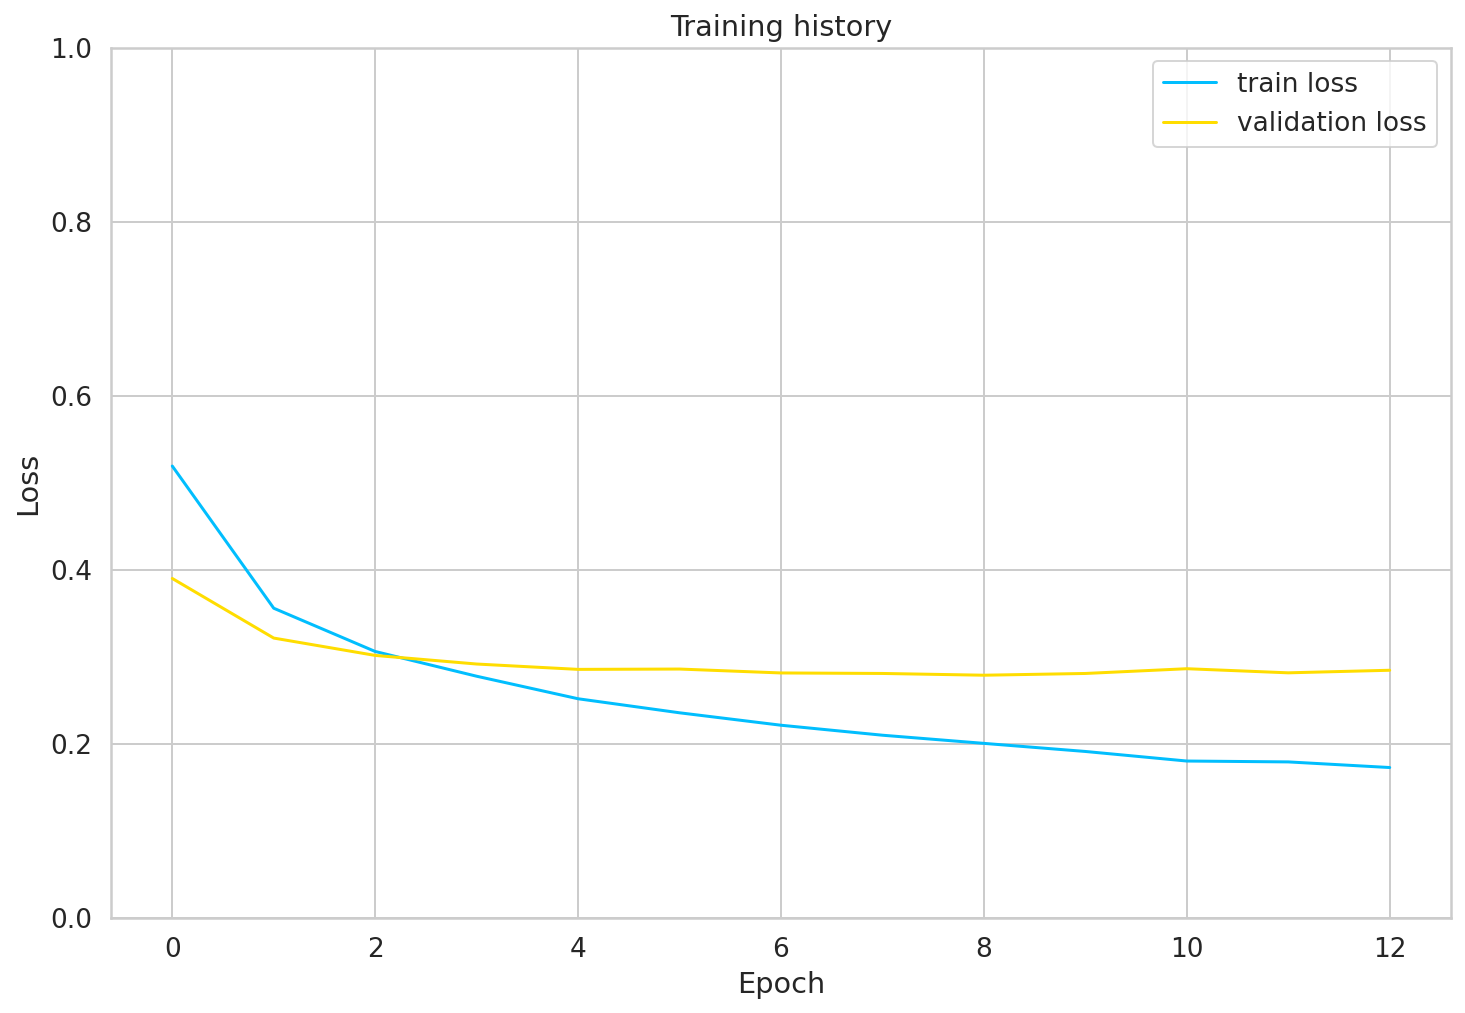

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);



##Evaluation

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
      for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask
          )
          preds = F.softmax(preds, dim=1)
          #review_texts.extend(texts)
          #predictions.extend(preds)
          prediction_probs.extend(preds)
          real_values.extend(targets)
    #predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return prediction_probs, real_values

In [ ]:
dev.head()

,tweet_text,claim_worthiness
0,باقي هذا المجرم الجبار المتكبر وابنائه الجبابر...,0
1,الان عودة الاشتباكات العنيفه في نهم والجيش الو...,1
2,الوية العمالقة تعلن النفير العام للاستعداد لاق...,0
3,في الاسواق اغاني جديده الحوثيين راح يفبركون ...,0
4,السعودية و الإمارات من محرريين لليمن إلى احت...,0


In [ ]:
dev.rename(columns={'tweet_text': 'text'}, inplace=True)
dev.rename(columns={'claim_worthiness': 'label'}, inplace=True)

In [ ]:
test_data_loader = dataLoader(dev, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_ap, test_loss= eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(dev)
)

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


In [ ]:
test_ap

0.868876642129312

In [ ]:
y_pred_prob,y_true = get_predictions(model,test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
y_pred_prob

tensor([[0.9927, 0.0073],
        [0.1934, 0.8066],
        [0.9216, 0.0784],
        ...,
        [0.9878, 0.0122],
        [0.5774, 0.4226],
        [0.9624, 0.0376]])

In [ ]:
#y_pred = y_pred_prob[:,0]-y_pred_prob[:,1]

In [ ]:
out = []
for num in y_pred_prob[:,1]:
  output = f"{num:.20f}"
  out.append(output)

In [ ]:
out

['0.00726907188072800636',
 '0.80664002895355224609',
 '0.07836176455020904541',
 '0.20394733548164367676',
 '0.00863367412239313126',
 '0.00757201481610536575',
 '0.00604838505387306213',
 '0.00597337819635868073',
 '0.00613839132711291313',
 '0.01385498046875000000',
 '0.11778719723224639893',
 '0.00662844441831111908',
 '0.00759125640615820885',
 '0.01145349722355604172',
 '0.43793171644210815430',
 '0.03881624713540077209',
 '0.03968356177210807800',
 '0.89752167463302612305',
 '0.88021767139434814453',
 '0.01586606353521347046',
 '0.47742074728012084961',
 '0.92351287603378295898',
 '0.93758577108383178711',
 '0.92351287603378295898',
 '0.93488478660583496094',
 '0.02129356190562248230',
 '0.10583025217056274414',
 '0.00788789242506027222',
 '0.80192345380783081055',
 '0.00665649631991982460',
 '0.00724083418026566505',
 '0.15145316720008850098',
 '0.01021776534616947174',
 '0.01558378618210554123',
 '0.89840739965438842773',
 '0.01043634582310914993',
 '0.00760700320824980736',
 

In [ ]:
sub['score'] = out

In [ ]:
%cd /content/clef2021-checkthat-lab/task1/scorer

/content/clef2021-checkthat-lab/task1/scorer


In [ ]:
sub.to_csv('sub.tsv',sep='\t',index=False,header=None)

In [ ]:
'''path="/content/clef2021-checkthat-lab/task1/scorer/new_test.csv"

import csv
reader = list(csv.reader(open(path, "rU"), delimiter=','))
writer = csv.writer(open(path, 'w'), delimiter='\t')
writer.writerows(row for row in reader)'''

'path="/content/clef2021-checkthat-lab/task1/scorer/new_test.csv"\n\nimport csv\nreader = list(csv.reader(open(path, "rU"), delimiter=\',\'))\nwriter = csv.writer(open(path, \'w\'), delimiter=\'\t\')\nwriter.writerows(row for row in reader)'

In [ ]:
!python3 subtask_1a.py --gold-file-path=CT21-AR-Dev-T1-Labels.tsv --pred-file-path=sub.tsv

INFO : Started evaluating results for subtask-1a ...
INFO : Reading gold predictions from file CT21-AR-Dev-T1-Labels.tsv
INFO : Reading predicted ranking order from file sub.tsv
INFO : ================================================= RESULTS for sub.tsv ==================================================
INFO : AVERAGE PRECISION:            0.8511    
INFO : ========================================================================================================================
INFO : RECIPROCAL RANK:              1.0000    
INFO : ========================================================================================================================
INFO : R-PRECISION (R=265):          0.7623    
INFO : ========================================================================================================================
INFO : PRECISION@N:                  @1        @3        @5        @10       @20       @50       
INFO :                               1.0000    1.0000    0.8000    0

In [ ]:
       
       #epoch badeleteha 5 
#batch_size = 32 , maxlength = 128 , lr=2e-5
#early stopping epoch 10